In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sklearn.model_selection import GroupShuffleSplit

# Creating Dataset 

In [11]:
pitching = pd.read_csv('Data/Lahman/Pitching.csv')
players = pd.read_csv('Data/Lahman/People.csv', encoding='latin1')

pitching_cols = [
    'playerID', 'yearID', 'teamID', 'stint', 'W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 
    'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp', 'ERA', 'WP', 'BK', 'BFP', 'GF'
]
pitching = pitching[pitching_cols]

# Merge datasets and drop unneccesary columns
pitchers = pd.merge(pitching, players, on='playerID', how='left')
pitchers['age'] = pitchers['yearID'] - pitchers['birthYear']
pitchers.drop(columns=['birthYear', 'birthMonth', 'birthDay', 'birthCity',
       'birthCountry', 'birthState', 'deathYear', 'deathMonth', 'deathDay',
       'deathCountry', 'deathState', 'deathCity', 'teamID','nameFirst', 'nameLast', 'nameGiven',
       'weight', 'height', 'bats', 'debut', 'bbrefID', 'finalGame',
       'retroID',], inplace=True)

# Imputation
pitchers['BAOpp'] = pitchers.groupby('playerID')['BAOpp'].transform(lambda x: x.fillna(x.mean()))
pitchers['ERA'] = pitchers.apply(lambda row: ((9 * row['ER']) / row['IPouts'] if row['IPouts'] != 0 else 0) if pd.isnull(row['ERA']) else row['ERA'], axis=1)
pitchers['BFP'] = pitchers.apply(lambda row: row['H'] + row['BB'] if pd.isnull(row['BFP']) else row['BFP'], axis=1)
pitchers['throws'] = pitchers.groupby('playerID')['throws'].transform(lambda x: x.fillna(method='ffill'))
#pitchers['age'] = pitchers.groupby('playerID')['age'].transform(lambda x: x.fillna(method='bfill'))

# Drop players that are only in the dataset for one year or all their rows contain NA values
players_one_year = pitchers.groupby('playerID')['yearID'].nunique()
players_to_remove = players_one_year[players_one_year == 1].index
pitchers = pitchers[~pitchers['playerID'].isin(players_to_remove)]
pitchers = pitchers.dropna(subset=['age'])
pitchers = pitchers.dropna(subset=['throws'])
pitchers = pitchers.dropna(subset=['BAOpp'])


pitchers.columns

Index(['playerID', 'yearID', 'stint', 'W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV',
       'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp', 'ERA', 'WP', 'BK',
       'BFP', 'GF', 'ID', 'throws', 'age'],
      dtype='object')

In [12]:
#pitchers.isna().sum()

In [13]:
pitchers.columns

Index(['playerID', 'yearID', 'stint', 'W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV',
       'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp', 'ERA', 'WP', 'BK',
       'BFP', 'GF', 'ID', 'throws', 'age'],
      dtype='object')

# Finding Peak Years

In [14]:
high_better_features= ['W', 'SV', 'SO', 'SHO', 'IPouts']
low_better_features= ['L', 'H', 'ER', 'BB', 'BAOpp', 'ERA', 'WP', 'HR', 'BK']

peak_data = []

# Process high-better features (max value)
for feature in high_better_features:
    # Find the max value per player for the current feature
    peak_values = pitchers.groupby('playerID')[feature].transform('max')
    threshold_values = 0.9 * peak_values
    
    # Determine the year when each player reached their peak value for this feature
    pitchers[f'peak_threshold_met_{feature}'] = pitchers[feature] >= threshold_values
    # Sort by yearID descending so latest years are prioritized
    pitchers_sorted = pitchers.sort_values(by='yearID', ascending=False)
    
    # Get the latest year where the peak threshold was met
    
    peak_years = pitchers_sorted[
        pitchers_sorted[f'peak_threshold_met_{feature}']
    ][['playerID', 'yearID']].drop_duplicates('playerID', keep='first')  # 'keep=first' ensures the latest year is retained
    
    peak_years = peak_years.rename(columns={'yearID': f'peak_year_{feature}'})
    
    # Store the peak year and value in a list
    peak_data.append(peak_years.set_index('playerID'))

# Process low-better features (min value)
for feature in low_better_features:
    # Find the min value per player for the current feature
    peak_values = pitchers.groupby('playerID')[feature].transform('min')
    threshold_values = 1.1 * peak_values  # Increase threshold to 110% of the peak for low-better features
    
    # Determine the year when each player reached their peak value for this feature
    pitchers[f'peak_threshold_met_{feature}'] = pitchers[feature] <= threshold_values
    pitchers_sorted = pitchers.sort_values(by='yearID', ascending=False)
    
    # Get the latest year where the peak threshold was met
    
    peak_years = pitchers_sorted[
        pitchers_sorted[f'peak_threshold_met_{feature}']
    ][['playerID', 'yearID']].drop_duplicates('playerID', keep='first')  # 'keep=first' ensures the latest year is retained
    
    peak_years = peak_years.rename(columns={'yearID': f'peak_year_{feature}'})
    
    # Store the peak year and value in a list
    peak_data.append(peak_years.set_index('playerID'))

# Merge all peak year data into one DataFrame
peak_info = pd.concat(peak_data, axis=1).reset_index()

# Merge the peak information back into the original DataFrame
pitchers = pitchers.merge(peak_info, on='playerID', how='left')

In [15]:
pitchers.head()

,playerID,yearID,stint,W,L,G,GS,CG,SHO,SV,...,peak_year_IPouts,peak_year_L,peak_year_H,peak_year_ER,peak_year_BB,peak_year_BAOpp,peak_year_ERA,peak_year_WP,peak_year_HR,peak_year_BK
0,aardsda01,2004,1,1,0,11,0,0,0,0,...,2009,2012,2012,2012,2012,2010,2009,2012,2012,2015
1,aardsda01,2006,1,3,0,45,0,0,0,0,...,2009,2012,2012,2012,2012,2010,2009,2012,2012,2015
2,aardsda01,2007,1,2,1,25,0,0,0,0,...,2009,2012,2012,2012,2012,2010,2009,2012,2012,2015
3,aardsda01,2008,1,4,2,47,0,0,0,0,...,2009,2012,2012,2012,2012,2010,2009,2012,2012,2015
4,aardsda01,2009,1,3,6,73,0,0,0,38,...,2009,2012,2012,2012,2012,2010,2009,2012,2012,2015


# Calculate League Averages by Season

In [16]:
selected_features = high_better_features + low_better_features
league_averages = pitchers.groupby('yearID')[selected_features].mean().reset_index()

# Rename columns to indicate they are league averages
league_averages = league_averages.rename(columns={feature: f'league_avg_{feature}' for feature in selected_features})
pitchers = pitchers.merge(league_averages, on='yearID')
pitchers.head()

,playerID,yearID,stint,W,L,G,GS,CG,SHO,SV,...,league_avg_IPouts,league_avg_L,league_avg_H,league_avg_ER,league_avg_BB,league_avg_BAOpp,league_avg_ERA,league_avg_WP,league_avg_HR,league_avg_BK
0,aardsda01,2004,1,1,0,11,0,0,0,0,...,197.911315,3.689602,67.574924,32.634557,24.636086,0.279446,5.686972,2.247706,8.256881,0.240061
1,aardsda01,2006,1,3,0,45,0,0,0,0,...,188.978006,3.542522,65.624633,31.645161,23.002933,0.278174,5.522859,2.203812,7.834311,0.211144
2,aardsda01,2007,1,2,1,25,0,0,0,0,...,188.663743,3.535088,65.057018,31.144737,23.192982,0.279383,5.858640,2.159357,7.135965,0.203216
3,aardsda01,2008,1,4,2,47,0,0,0,0,...,190.873156,3.560472,64.455752,30.473451,23.883481,0.271369,5.073230,2.281711,7.137168,0.225664
4,aardsda01,2009,1,3,6,73,0,0,0,38,...,183.514936,3.428165,61.455192,29.274538,23.384068,0.272902,5.534680,2.243243,7.115220,0.194879


# Defining Decline Event

In [17]:
decline_threshold = 0.5

pitchers['decline_event'] = pitchers.apply(
    lambda row: (
        # Count the number of high-better features below league average and after peak
        sum([
            (row['yearID'] > row[f'peak_year_{feature}']) and (row[feature] < row[f'league_avg_{feature}'])
            for feature in high_better_features
        ]) +
        # Count the number of low-better features above league average and after peak
        sum([
            (row['yearID'] > row[f'peak_year_{feature}']) and (row[feature] > row[f'league_avg_{feature}'])
            for feature in low_better_features
        ])
    ) / (len(high_better_features) + len(low_better_features))  # Normalize by total features
    >= decline_threshold  # Compare against the threshold
, axis=1)

# Check the decline event column for a few players
pitchers[['playerID', 'yearID', 'decline_event']].head()

,playerID,yearID,decline_event
0,aardsda01,2004,False
1,aardsda01,2006,False
2,aardsda01,2007,False
3,aardsda01,2008,False
4,aardsda01,2009,False


# Preparing Data for Survival Analysis

In [18]:
# Step 1: Remove league average columns
columns_to_drop = [col for col in pitchers.columns if col.startswith('league_avg_')]
pitchers = pitchers.drop(columns=columns_to_drop)

# Step 2: Create first_year and decline_year
first_years = pitchers.groupby('playerID')['yearID'].min().rename('first_year')
decline_years = (
    pitchers[pitchers['decline_event']]
    .groupby('playerID')['yearID']
    .min()
    .rename('decline_year')
)

# Merge first_year and decline_year into the main DataFrame
pitchers = pitchers.merge(first_years, on='playerID', how='left')
pitchers = pitchers.merge(decline_years, on='playerID', how='left')

# Step 3: Assign decline_year for players without a decline event
# Get the last year for each player
last_years = pitchers.groupby('playerID')['yearID'].max().rename('last_year')

# Merge last_year into the DataFrame
pitchers = pitchers.merge(last_years, on='playerID', how='left')

# Fill decline_year with last_year for players without a decline event
pitchers['decline_year'] = pitchers['decline_year'].fillna(pitchers['last_year'])

# Step 5: Calculate time_to_event
# Initial calculation for all rows
pitchers['time_to_event'] = pitchers['decline_year'] - pitchers['first_year']

# Step 6: Ensure consistent time_to_event for players with a decline event
# For players with a decline event, propagate the same time_to_event across all their rows
pitchers['time_to_event'] = pitchers.groupby('playerID')['time_to_event'].transform('first')

# Step 7: Clean up unnecessary columns
pitchers.drop(columns=['first_year', 'last_year'], inplace=True)

In [19]:
pitchers['playerID'].nunique()

6782

In [20]:
pitchers[pitchers['decline_event']==True]['playerID'].nunique()

1966

In [21]:
survival_data = pitchers.copy()
survival_data['decline_event'] = survival_data['decline_event'].astype(int)
survival_data = survival_data.drop(columns=['peak_threshold_met_W',
       'peak_threshold_met_SV', 'peak_threshold_met_SO',
       'peak_threshold_met_SHO', 'peak_threshold_met_IPouts',
       'peak_threshold_met_L', 'peak_threshold_met_H', 'peak_threshold_met_ER',
       'peak_threshold_met_BB', 'peak_threshold_met_BAOpp',
       'peak_threshold_met_ERA', 'peak_threshold_met_WP',
       'peak_threshold_met_HR', 'peak_threshold_met_BK', 'peak_year_W',
       'peak_year_SV', 'peak_year_SO', 'peak_year_SHO', 'peak_year_IPouts',
       'peak_year_L', 'peak_year_H', 'peak_year_ER', 'peak_year_BB',
       'peak_year_BAOpp', 'peak_year_ERA', 'peak_year_WP', 'peak_year_HR',
       'peak_year_BK'])
survival_data

,playerID,yearID,stint,W,L,G,GS,CG,SHO,SV,...,WP,BK,BFP,GF,ID,throws,age,decline_event,decline_year,time_to_event
0,aardsda01,2004,1,1,0,11,0,0,0,0,...,0,0,61.0,5,1,R,23.0,0,2015.0,11.0
1,aardsda01,2006,1,3,0,45,0,0,0,0,...,1,0,225.0,9,1,R,25.0,0,2015.0,11.0
2,aardsda01,2007,1,2,1,25,0,0,0,0,...,2,0,151.0,7,1,R,26.0,0,2015.0,11.0
3,aardsda01,2008,1,4,2,47,0,0,0,0,...,3,0,228.0,7,1,R,27.0,0,2015.0,11.0
4,aardsda01,2009,1,3,6,73,0,0,0,38,...,2,0,296.0,53,1,R,28.0,0,2015.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45033,zuverge01,1958,1,2,2,45,0,0,0,7,...,2,0,294.0,23,20674,R,34.0,0,1959.0,8.0
45034,zuverge01,1959,1,0,1,6,0,0,0,0,...,1,0,55.0,1,20674,R,35.0,0,1959.0,8.0
45035,zychto01,2015,1,0,0,13,1,0,0,0,...,1,0,76.0,4,20676,R,25.0,0,2017.0,2.0
45036,zychto01,2016,1,1,0,12,0,0,0,0,...,0,0,60.0,3,20676,R,26.0,0,2017.0,2.0


In [22]:
# Ensure your dataset is sorted by playerID and yearID
survival_data = survival_data.sort_values(by=["playerID", "yearID"])

# List of columns for which we will compute trends
trend_columns = ['W', 'L', 'G', 'CG', 'SHO', 'SV',
       'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp', 'ERA', 'WP', 'BK',
       'BFP']

# Year-over-Year Differences
for col in trend_columns:
    survival_data[f'{col}_diff'] = survival_data.groupby('playerID')[col].diff()

# Rolling Averages (3-Year Rolling)
for col in trend_columns:
    survival_data[f'{col}_rolling_avg'] = (
        survival_data
        .groupby('playerID')[col]
        .rolling(3, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

# Cumulative Sums
for col in trend_columns:
    survival_data[f'{col}_cumsum'] = survival_data.groupby('playerID')[col].cumsum()


# Change right-handed throwers to 1 and left-handed throwers to 0 and switch hitters to 2
survival_data['throws'] = survival_data['throws'].map({'R': 1, 'L':0, 'S': 2})

# Drop any rows introduced with NaN values due to `.diff()` or `.shift()` for better alignment
survival_data.dropna(subset=[f'{col}_diff' for col in trend_columns], inplace=True)


# Reset index for a clean dataframe
survival_data.reset_index(drop=True, inplace=True)


# Survival Analysis

In [53]:
#Prepare data for survival analysis
y = Surv.from_dataframe("decline_event", "time_to_event", survival_data)

# Extract features (excluding playerID and yearID)
features = survival_data.drop(columns=["playerID", "yearID"])

# Check for missing values
assert not features.isnull().any().any(), "NaNs remain in features!"

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets, keeping playerID groups intact
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X_scaled, groups=survival_data['playerID']))
X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Train the RSF model
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=3, random_state=42)
rsf.fit(X_train, y_train)

# Evaluate the model
train_score = rsf.score(X_train, y_train)
test_score = rsf.score(X_test, y_test)
print(f"Training Concordance Index: {train_score}")
print(f"Test Concordance Index: {test_score}")

# Step 8: Predict survival functions and decline years
survival_functions = rsf.predict_survival_function(X_test)

# Determine predicted decline years for each player
decline_years = []
for i, surv_func in enumerate(survival_functions):
    decline_year = next((t for t, s in zip(surv_func.x, surv_func.y) if s < 0.5), None)
    decline_years.append(2024 - decline_year if decline_year else "No Decline Detected")

# Extract actual time_to_event and event values from y_test
time_to_event_test = y_test["time_to_event"]
event_test = y_test["decline_event"]

# Step 9: Attach the predictions to the test results
test_results = pd.DataFrame(X_test, columns=features.columns)
test_results["predicted_decline_year"] = decline_years
test_results["actual_time_to_event"] = time_to_event_test
test_results["event"] = event_test
print(test_results)

Training Concordance Index: 0.9840477385489474
Test Concordance Index: 0.9771157713165965
         stint         W         L         G        GS        CG       SHO  \
0    -0.315807 -0.717488 -0.819073 -1.114246 -0.796845 -0.454083 -0.397227   
1     2.819806 -0.161158 -0.385873 -0.522936  0.026731 -0.063583 -0.397227   
2    -0.315807  0.024286  1.346929  0.283397  0.685592  0.326917 -0.397227   
3    -0.315807  0.209729 -0.385873  0.659685 -0.714487 -0.454083 -0.397227   
4    -0.315807 -0.161158 -0.169273  0.820952 -0.796845 -0.454083 -0.397227   
...        ...       ...       ...       ...       ...       ...       ...   
7327  2.819806  0.766059  0.263928 -0.200403  0.191447  0.326917  0.534777   
7328 -0.315807 -0.717488 -0.602473  0.014619 -0.796845 -0.454083 -0.397227   
7329 -0.315807 -0.161158 -0.602473  0.337152 -0.549772 -0.454083 -0.397227   
7330 -0.315807  0.209729  1.130329 -0.039136  0.685592  1.107918  0.534777   
7331 -0.315807 -0.902932  0.263928 -0.576691  0.0267

In [24]:
test_results[test_results['predicted_decline_year'] != 'No Decline Detected']

,stint,W,L,G,GS,CG,SHO,SV,IPouts,H,...,BB_cumsum,SO_cumsum,BAOpp_cumsum,ERA_cumsum,WP_cumsum,BK_cumsum,BFP_cumsum,predicted_decline_year,actual_time_to_event,event
17,-0.315807,-0.532045,1.130329,2.272350,-0.796845,-0.454083,-0.397227,4.117717,-0.023897,-0.066492,...,-0.519664,-0.331986,-0.298430,-0.589733,-0.640804,0.098636,-0.449896,2020.0,4.0,True
18,-0.315807,-0.161158,-0.819073,-0.845469,-0.302699,-0.454083,-0.397227,-0.330068,-0.627512,-0.567719,...,-0.426472,-0.280471,-0.184819,-0.341386,-0.640804,0.573400,-0.394752,2020.0,4.0,True
19,-0.315807,-0.717488,-0.602473,-0.899224,-0.796845,-0.454083,-0.397227,-0.330068,-0.854403,-0.818333,...,-0.409528,-0.246128,-0.071207,-0.008213,-0.640804,0.810782,-0.367017,2019.0,4.0,True
22,-0.315807,0.024286,1.563529,0.659685,1.426811,-0.454083,-0.397227,-0.330068,0.922194,1.358048,...,-0.545080,-0.374916,-0.327622,-0.366425,-0.451969,-0.376128,-0.452833,2021.0,3.0,True
23,-0.315807,-0.532045,-0.169273,0.498419,-0.385057,-0.454083,-0.397227,-0.152157,-0.280755,0.012649,...,-0.477304,-0.308375,-0.200993,-0.035807,-0.451969,-0.138746,-0.357554,2021.0,3.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7245,-0.315807,-0.532045,0.263928,-0.952980,-0.055626,-0.258833,-0.397227,-0.330068,-0.618950,-0.449007,...,1.704246,0.998818,0.935121,2.221800,0.256162,-0.138746,1.487325,2012.0,13.0,True
7246,-0.315807,-0.902932,0.480528,-0.899224,0.026731,-0.063583,-0.397227,-0.330068,-0.443431,-0.172013,...,1.763550,1.020283,1.065301,2.490587,0.256162,-0.138746,1.565310,2011.0,13.0,True
7276,-0.315807,-0.346601,0.913729,0.390908,0.273804,-0.454083,-0.397227,-0.152157,0.036036,0.250073,...,1.111203,1.380888,0.308680,0.822676,0.917085,1.048164,0.851047,2014.0,12.0,True
7308,-0.315807,-0.161158,0.263928,-0.469180,0.109089,0.717418,0.534777,0.025755,0.250084,0.856821,...,-0.617092,-0.619612,-0.122096,-0.412926,-0.640804,-0.613510,-0.454138,2018.0,10.0,True


In [25]:
predicted_decline_years = [
    2024 - year if year != "No Decline Detected" else None
    for year in decline_years
]

# Create a DataFrame with the predictions and actual time-to-event values
test_results["predicted_decline_years"] = predicted_decline_years

# Remove rows where predicted decline year is None (i.e., "No Decline Detected")
valid_predictions = test_results.dropna(subset=["predicted_decline_years"])

# Calculate Mean Absolute Error (MAE) between predicted and actual decline years
# Only for rows where we have valid predictions
mae = mean_absolute_error(valid_predictions["actual_time_to_event"], valid_predictions["predicted_decline_years"])
print(f"Mean Absolute Error (MAE): {mae}")

# Additionally, you can define a tolerance threshold for "correct" predictions
tolerance = 1 # Define the tolerance in years (e.g., within 1 year of the actual decline year)
correct_predictions = valid_predictions[
    abs(valid_predictions["actual_time_to_event"] - valid_predictions["predicted_decline_years"]) <= tolerance
]

# Calculate prediction accuracy within the tolerance
accuracy_within_tolerance = len(correct_predictions) / len(valid_predictions) * 100
print(f"Accuracy within {tolerance} years: {accuracy_within_tolerance}%")

Mean Absolute Error (MAE): 0.8528528528528528
Accuracy within 1 years: 83.48348348348348%


## Error Visualization

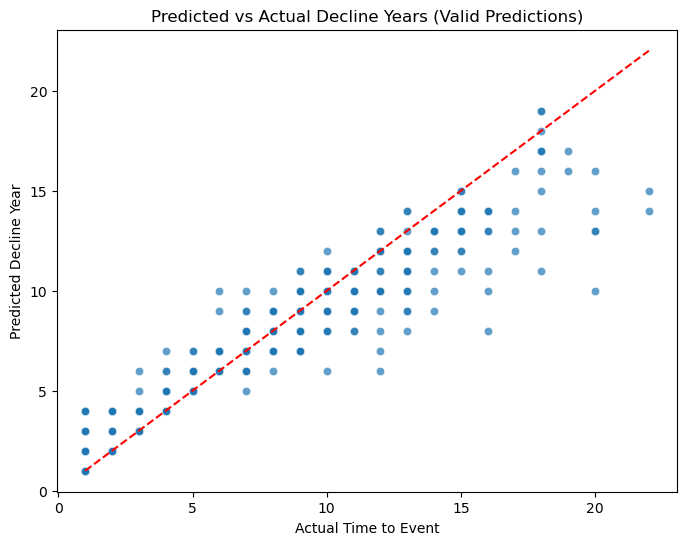

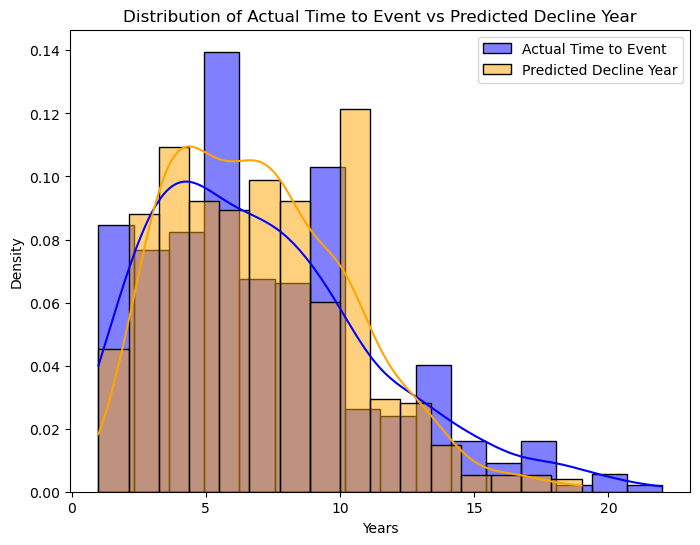

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot: Predicted vs Actual Decline Years for valid predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=valid_predictions["actual_time_to_event"], 
                y=valid_predictions["predicted_decline_years"], 
                alpha=0.7)
plt.plot([valid_predictions["actual_time_to_event"].min(), valid_predictions["actual_time_to_event"].max()], 
         [valid_predictions["actual_time_to_event"].min(), valid_predictions["actual_time_to_event"].max()], 
         color='red', linestyle='--')  # Line of perfect prediction
plt.title("Predicted vs Actual Decline Years (Valid Predictions)")
plt.xlabel("Actual Time to Event")
plt.ylabel("Predicted Decline Year")
plt.show()

# Plot: Distribution of Predicted vs Actual Decline Years
plt.figure(figsize=(8, 6))
sns.histplot(valid_predictions["actual_time_to_event"], kde=True, color='blue', label='Actual Time to Event', stat='density')
sns.histplot(valid_predictions["predicted_decline_years"], kde=True, color='orange', label='Predicted Decline Year', stat='density')
plt.title("Distribution of Actual Time to Event vs Predicted Decline Year")
plt.xlabel("Years")
plt.ylabel("Density")
plt.legend()
plt.show()




In [55]:
from sklearn.inspection import permutation_importance

# Evaluate the model on the test set
result = permutation_importance(rsf, X_test, y_test, n_repeats=10, random_state=42)

# Get the importances and sort them
importances = result.importances_mean
stds = result.importances_std

# Create a DataFrame to view the importance of each feature
importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': importances,
    'Std': stds
})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Permutation Feature Importance Ranking:")
print(importance_df)

# Select top k most important features (adjust k as needed)
k = 10  # For example, select top 10 features
top_k_features = importance_df.head(k)['Feature'].values

print(f"Top {k} features selected: {top_k_features}")


Permutation Feature Importance Ranking:
               Feature  Importance       Std
23       decline_event    0.129235  0.002895
25       time_to_event    0.004961  0.000508
73          ERA_cumsum    0.002356  0.000135
70           BB_cumsum    0.001388  0.000155
66       IPouts_cumsum    0.001210  0.000122
..                 ...         ...       ...
55   BAOpp_rolling_avg   -0.000338  0.000132
49  IPouts_rolling_avg   -0.000342  0.000070
8               IPouts   -0.000430  0.000115
15                 ERA   -0.001105  0.000262
14               BAOpp   -0.001304  0.000311

[77 rows x 3 columns]
Top 10 features selected: ['decline_event' 'time_to_event' 'ERA_cumsum' 'BB_cumsum' 'IPouts_cumsum'
 'BFP_cumsum' 'BAOpp_cumsum' 'ER_cumsum' 'ER' 'SO_cumsum']
